<a href="https://colab.research.google.com/github/candido05/ML_Projects/blob/main/SROIE_LayoutLM_NER_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!pip install torch datasets

In [ ]:
import os

# Baixar e descompactar o dataset
!kaggle datasets download -d onchutrng/sroie20192021 -p /content
import zipfile
with zipfile.ZipFile('/content/sroie20192021.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sroie20192021')
os.remove('/content/sroie20192021.zip')

print("Dataset disponível em /content/sroie20192021")

Dataset URL: https://www.kaggle.com/datasets/onchutrng/sroie20192021
License(s): unknown
100% 1.83G/1.84G [00:22<00:00, 93.8MB/s]
100% 1.84G/1.84G [00:22<00:00, 86.8MB/s]
Dataset disponível em /content/sroie20192021


In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
from IPython.display import display
import torch
from datasets import Dataset

from transformers import LayoutLMTokenizer, LayoutLMForTokenClassification
from transformers import TrainingArguments, Trainer

### Análise dos Dados

In [ ]:
# Caminho base do dataset
sroie_base_path = Path('/content/sroie20192021/SROIE2019-20210928T080219Z-001/SROIE2019')

# Exemplo específico fornecido
example_txt = Path('0325updated.task1train(626p)/X51005268262.txt')
example_img = Path('0325updated.task1train(626p)/X51005268262.jpg')

# Verificar se os arquivos existem
txt_path = sroie_base_path / example_txt
img_path = sroie_base_path / example_img

print(f"Caminho do arquivo de texto: {txt_path}")
print(f"Arquivo existe? {txt_path.exists()}")
print(f"Caminho da imagem: {img_path}")
print(f"Imagem existe? {img_path.exists()}")

Caminho do arquivo de texto: /content/sroie20192021/SROIE2019-20210928T080219Z-001/SROIE2019/0325updated.task1train(626p)/X51005268262.txt
Arquivo existe? True
Caminho da imagem: /content/sroie20192021/SROIE2019-20210928T080219Z-001/SROIE2019/0325updated.task1train(626p)/X51005268262.jpg
Imagem existe? True


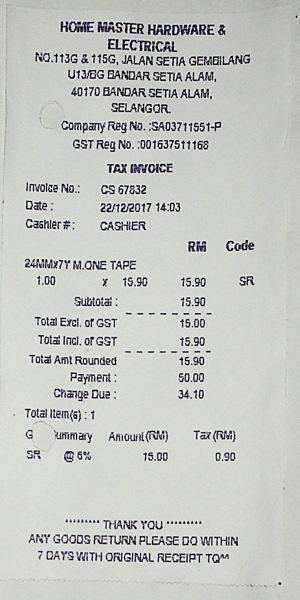

In [ ]:
image = Image.open(img_path)
image = image.convert("RGB")
new_image = image.resize((300, 600))
new_image

### Lendo as letras e delimitadores das imagens

In [ ]:
sroie_base_path = Path('/content/sroie20192021/SROIE2019-20210928T080219Z-001/SROIE2019')
txt_path = sroie_base_path / "0325updated.task1train(626p)" / "X51005757324.txt"

print(f"Caminho do arquivo: {txt_path}")
print(f"Arquivo existe? {txt_path.exists()}")

Caminho do arquivo: /content/sroie20192021/SROIE2019-20210928T080219Z-001/SROIE2019/0325updated.task1train(626p)/X51005757324.txt
Arquivo existe? True


In [ ]:
def read_bbox_and_words(path: Path):
    """
    Lê um arquivo .txt do SROIE2019 (task1train) e retorna um DataFrame com filename, bounding box (x0, y0, x2, y2) e texto.
    """
    bbox_and_words_list = []

    with open(path, 'r', encoding='utf-8') as f:
        for line in f.read().splitlines():
            if line.strip():
                split_lines = line.split(",")
                bbox = np.array(split_lines[0:8], dtype=np.int32)
                text = ",".join(split_lines[8:])
                bbox_and_words_list.append([path.stem, bbox[0], bbox[1], bbox[4], bbox[5], text])

    dataframe = pd.DataFrame(
        bbox_and_words_list,
        columns=['filename', 'x0', 'y0', 'x2', 'y2', 'line']
    )

    numeric_columns = ['x0', 'y0', 'x2', 'y2']
    dataframe[numeric_columns] = dataframe[numeric_columns].astype(np.int16)

    return dataframe

In [ ]:
bbox_df = read_bbox_and_words(txt_path)
bbox_df.head(10)

,filename,x0,y0,x2,y2,line
0,X51005757324,153,253,516,286,MR. D.I.Y. (M) SDN BHD
1,X51005757324,190,287,482,318,(CO. REG :860671-D)
2,X51005757324,56,321,596,354,"LOT 1851-A & 1851-B, JALAN KPB 6 ,"
3,X51005757324,70,355,579,388,"KAWASAN PERINDUSTRIAN BALAKONG ,"
4,X51005757324,88,389,583,418,"43300 SERI KEMBANGAN, SELANGOR"
5,X51005757324,124,424,532,455,(GST ID NO :000306020352)
6,X51005757324,222,455,432,486,(IOI PUCHONG)
7,X51005757324,220,490,434,518,-TAX INVOICE-
8,X51005757324,8,557,583,588,TRAC DRY IRON TR-231IR - 1200W(SR) N
9,X51005757324,632,559,669,586,*S


In [ ]:
print("== File content ==")
with open(txt_path, 'r', encoding='utf-8') as f:
    lines = f.read().splitlines()
    for line in lines[-10:]:
        print(line)

== File content ==
6,928,104,928,104,955,6,955,CHANGE
550,929,665,929,665,958,550,958,RM 0.20
7,995,416,995,416,1025,7,1025,GST @6% INCLUDED IN TOTAL
502,997,616,997,616,1024,502,1024,RM 2.88
7,1063,402,1063,402,1092,7,1092,25-03-18 18:47 SHO1 ZJ86
453,1064,665,1064,665,1092,453,1092,T1 R000112415
6,1096,403,1096,403,1126,6,1126,OPERATOR TRAINEE CASHIER
107,1165,552,1165,552,1194,107,1194,EXCHANGE ARE ALLOWED WITHIN
171,1198,482,1198,482,1228,171,1228,7 DAY WITH RECEIPT.
139,1231,531,1231,531,1262,139,1262,STRICTLY NO CASH REFUND .


In [ ]:
print("\n== Tipos das colunas ==")
print(bbox_df.dtypes)


== Tipos das colunas ==
filename    object
x0           int16
y0           int16
x2           int16
y2           int16
line        object
dtype: object


### Lendo o arquivo de entidades

In [ ]:
sroie_folder_path = Path('/content/sroie20192021/SROIE2019-20210928T080219Z-001/SROIE2019')
example_file = Path('0325updated.task2train(626p)/X51005268262.txt')
entities_file_path = sroie_folder_path / example_file

print(f"Caminho do arquivo: {entities_file_path}")
print(f"Arquivo existe? {entities_file_path.exists()}")
print("== File content ==")
with open(entities_file_path, 'r', encoding='utf-8') as f:
    for line in f.readlines()[:5]:  # Primeiras 5 linhas
        print(line.strip())

Caminho do arquivo: /content/sroie20192021/SROIE2019-20210928T080219Z-001/SROIE2019/0325updated.task2train(626p)/X51005268262.txt
Arquivo existe? True
== File content ==
{
"company": "HOME MASTER HARDWARE & ELECTRICAL",
"date": "22/12/2017",
"address": "NO.113G & 115G, JALAN SETIA GEMBILANG U13/BG BANDAR SETIA ALAM, 40170 BANDAR SETIA ALAM, SELANGOR.",
"total": "15.90"


In [ ]:
# Função para ler entidades (mantida do código original)
import json

def read_entities(path: Path):
    """
    Lê um arquivo JSON do SROIE2019 (task2train) e retorna um DataFrame com as entidades.
    """
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    dataframe = pd.DataFrame([data])
    return dataframe

In [ ]:
entities = read_entities(entities_file_path)
print("\n\n== Dataframe ==")
display(entities)



== Dataframe ==


,company,date,address,total
0,HOME MASTER HARDWARE & ELECTRICAL,22/12/2017,"NO.113G & 115G, JALAN SETIA GEMBILANG U13/BG B...",15.90


### Realizando o pré-processamento de dados

In [ ]:
# Função para atribuir rótulos a linhas (mantida do código original)
from difflib import SequenceMatcher

def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()
        matches_count = 0

        for l in line_set:
            if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
                matches_count += 1

        if matches_count == len(line_set) or matches_count == len(entity_set):
            return column.upper()

    return "O"

In [ ]:
line = bbox_df.loc[0,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)

Line: MR. D.I.Y. (M) SDN BHD
Assigned label: O


In [ ]:
sroie_base_path = Path('/content/sroie20192021/SROIE2019-20210928T080219Z-001/SROIE2019')

bbox_file_path = sroie_base_path / "0325updated.task1train(626p)" / "X51005268262.txt"
entities_file_path = sroie_base_path / "0325updated.task2train(626p)" / "X51005268262.txt"

print(f"Arquivo de bounding boxes: {bbox_file_path}")
print(f"Existe? {bbox_file_path.exists()}")
print(f"Arquivo de entidades: {entities_file_path}")
print(f"Existe? {entities_file_path.exists()}")

Arquivo de bounding boxes: /content/sroie20192021/SROIE2019-20210928T080219Z-001/SROIE2019/0325updated.task1train(626p)/X51005268262.txt
Existe? True
Arquivo de entidades: /content/sroie20192021/SROIE2019-20210928T080219Z-001/SROIE2019/0325updated.task2train(626p)/X51005268262.txt
Existe? True


In [ ]:
# Função para atribuir rótulos ao DataFrame (mantida do código original)
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):

    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}
    already_labeled = {
        "TOTAL": False,
        "DATE": False,
        "ADDRESS": False,
        "COMPANY": False,
        "O": False
    }

    labels=[]
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)
        already_labeled[label] = True

        if label == "ADDRESS" and (already_labeled["DATE"] or already_labeled["TOTAL"]):
            label = "O"

        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words

# Função para dividir linhas em palavras (mantida do código original)
def split_line(line: pd.Series):
    """
    Divide uma linha em palavras e ajusta as coordenadas para cada palavra.
    """
    line_copy = line.copy()
    line_str = line_copy.loc["line"]
    words = line_str.split(" ")

    # Filtragem de tokens indesejáveis
    words = [word for word in words if len(word) >= 1]
    x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
    bbox_width = x2 - x0

    new_lines = []
    for index, word in enumerate(words):
        # Calcula o novo x2 proporcional ao comprimento da palavra
        x2_new = x0 + int(bbox_width * len(word) / len(line_str))
        # Cria uma cópia da série e atualiza os valores individualmente
        new_line = line_copy.copy()
        new_line.at['x0'] = x0
        new_line.at['x2'] = x2_new
        new_line.at['line'] = word
        new_lines.append(new_line.to_list())
        x0 = x2_new + 5  # Espaçamento entre palavras

    return new_lines

In [ ]:
# Processar o arquivo de bounding boxes
bbox_df = read_bbox_and_words(bbox_file_path)
print("== Bounding Boxes File Content (últimas 10 linhas) ==")
with open(bbox_file_path, 'r', encoding='utf-8') as f:
    lines = f.read().splitlines()
    for line in lines[-10:]:
        print(line)
print("\n== Bounding Boxes DataFrame (primeiras 5 linhas) ==")
print(bbox_df.head(5).to_string(index=True))

== Bounding Boxes File Content (últimas 10 linhas) ==
479,1010,590,1010,590,1041,479,1041,TAX(RM)
64,1058,103,1058,103,1081,64,1081,SR
156,1059,228,1059,228,1089,156,1089,@ 6%
354,1062,420,1062,420,1086,354,1086,15.00
533,1062,588,1062,588,1086,533,1086,0.90
254,1221,408,1221,408,1248,254,1248,THANK YOU
68,1254,596,1254,596,1286,68,1286,ANY GOODS RETURN PLEASE DO WITHIN
91,1295,573,1295,573,1326,91,1326,7 DAYS WITH ORIGINAL RECEIPT TQ^^
250,433,366,433,366,458,250,458,CS 67832
139,1014,232,1014,232,1043,139,1043,UMMARY

== Bounding Boxes DataFrame (primeiras 5 linhas) ==
       filename   x0   y0   x2   y2                                   line
0  X51005268262  146   47  565   84                 HOME MASTER HARDWARE &
1  X51005268262  266   89  444  125                             ELECTRICAL
2  X51005268262   85  120  625  156  NO.113G & 115G, JALAN SETIA GEMBILANG
3  X51005268262  166  161  542  193              U13/BG BANDAR SETIA ALAM,
4  X51005268262  174  201  529  235            

In [ ]:
# Processar o arquivo de entidades
entities = read_entities(entities_file_path)
print("== Entities File Content (primeiras 5 linhas) ==")
with open(entities_file_path, 'r', encoding='utf-8') as f:
    for line in f.readlines()[:5]:
        print(line.strip())
print("\n== Entities DataFrame ==")
display(entities)

== Entities File Content (primeiras 5 linhas) ==
{
"company": "HOME MASTER HARDWARE & ELECTRICAL",
"date": "22/12/2017",
"address": "NO.113G & 115G, JALAN SETIA GEMBILANG U13/BG BANDAR SETIA ALAM, 40170 BANDAR SETIA ALAM, SELANGOR.",
"total": "15.90"

== Entities DataFrame ==


,company,date,address,total
0,HOME MASTER HARDWARE & ELECTRICAL,22/12/2017,"NO.113G & 115G, JALAN SETIA GEMBILANG U13/BG B...",15.90


In [ ]:
# Teste com a primeira linha do bbox_df
line = bbox_df.loc[0, "line"]
label = assign_line_label(line, entities)
print("\n== Teste de Rotulação ==")
print("Line:", line)
print("Assigned label:", label)


== Teste de Rotulação ==
Line: HOME MASTER HARDWARE &
Assigned label: COMPANY


### Vizualização dos labels

In [ ]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):

    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}
    already_labeled = {
        "TOTAL": False,
        "DATE": False,
        "ADDRESS": False,
        "COMPANY": False,
        "O": False
    }

    labels=[]
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)
        already_labeled[label] = True

        if label == "ADDRESS" and (already_labeled["DATE"] or already_labeled["TOTAL"]):
            label = "O"

        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words

In [ ]:
bbox_labeled = assign_labels(bbox_df, entities)
bbox_labeled.head(10)

,filename,x0,y0,x2,y2,line,label
0,X51005268262,146,47,565,84,HOME MASTER HARDWARE &,COMPANY
1,X51005268262,266,89,444,125,ELECTRICAL,COMPANY
2,X51005268262,85,120,625,156,"NO.113G & 115G, JALAN SETIA GEMBILANG",ADDRESS
3,X51005268262,166,161,542,193,"U13/BG BANDAR SETIA ALAM,",ADDRESS
4,X51005268262,174,201,529,235,"40170 BANDAR SETIA ALAM,",ADDRESS
5,X51005268262,275,240,428,269,SELANGOR.,ADDRESS
6,X51005268262,150,281,553,315,COMPANY REG NO. :SA03711551-P,O
7,X51005268262,178,326,522,359,GST REG NO. :001637511168,O
8,X51005268262,263,383,433,409,TAX INVOICE,O
9,X51005268262,62,427,203,460,INVOLCE NO.:,O


In [ ]:
Color_labeled = {"TOTAL": "Red", "DATE": "Yellow",
                "ADDRESS": "Green", "COMPANY": "Blue",
                "O": "Gray"}

def Draw_BBox(image_path, _bbox_labeled: pd.DataFrame):
    actual_boxes = []

    for idx, row in _bbox_labeled.iterrows():
        x0 = row['x0']
        y0 = row['y0']
        x2 = row['x2']
        y2 = row['y2']
        label = row['label']
        color = Color_labeled[label]
        actual_box = [x0, y0, x2, y2]
        draw = ImageDraw.Draw(image, "RGB")
        draw.rectangle(actual_box, outline=color, width=4)
        new_image = image.resize((300, 600))
    return new_image

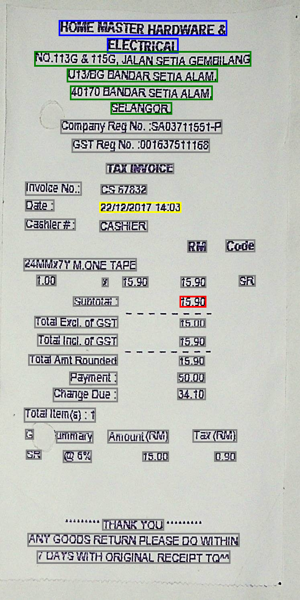

In [ ]:
Draw_BBox(image,bbox_labeled)

### Função para criar o dataset (adaptada para LayoutLM)

In [ ]:
def dataset_creator(folder: Path, total=1000):
    """
    Cria um dataset a partir dos arquivos de bounding boxes, entidades e imagens.
    Adaptado para LayoutLM: mantém as 4 coordenadas das bounding boxes.
    """
    bbox_folder = folder / '0325updated.task1train(626p)'
    entities_folder = folder / '0325updated.task2train(626p)'

    ignore = ['X51006619545.txt', 'X51006619785.txt', 'X51005663280(1).txt', 'X51005663280.txt']
    files = [file for file in bbox_folder.glob("*.txt") if file.name not in ignore]
    files = files[:total]

    data = []

    print("Reading dataset:")
    for file in tqdm(files, total=len(files)):
        bbox_file_path = file
        entities_file_path = entities_folder / file.name
        image_file_path = bbox_folder / file.with_suffix(".jpg")

        if not (bbox_file_path.is_file() and entities_file_path.is_file() and image_file_path.is_file()):
            continue

        # Leitura dos arquivos
        bbox = read_bbox_and_words(bbox_file_path)
        entities = read_entities(entities_file_path)
        image = Image.open(image_file_path)
        width, height = image.size

        # Atribuição de rótulos
        bbox_labeled = assign_labels(bbox, entities)
        del bbox

        # Divisão das linhas em tokens
        new_bbox_l = []
        for index, row in bbox_labeled.iterrows():
            new_bbox_l += split_line(row)
        new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns)
        new_bbox[['x0', 'y0', 'x2', 'y2']] = new_bbox[['x0', 'y0', 'x2', 'y2']].astype(np.int16)
        del bbox_labeled

        # Segunda atribuição de rótulos para maior precisão
        for index, row in new_bbox.iterrows():
            label = row['label']
            if label != "O":
                entity = entities.iloc[0, entities.columns.get_loc(label.lower())]
                if row['line'] not in entity:
                    label = "O"
                else:
                    label = "B-" + label  # Mudança: usando prefixo B- em vez de S-
                new_bbox.at[index, 'label'] = label

        # Criar dicionário de exemplo para LayoutLM
        example = {
            "words": new_bbox['line'].tolist(),
            "bboxes": [[row['x0'], row['y0'], row['x2'], row['y2']] for _, row in new_bbox.iterrows()],
            "labels": new_bbox['label'].tolist(),
            "image_path": str(image_file_path),
            "width": width,
            "height": height
        }
        data.append(example)

    return data

### Preparação do dataset para o LayoutLM

In [ ]:
# Definir os rótulos para o LayoutLM
label_list = ["O", "B-COMPANY", "B-ADDRESS", "B-DATE", "B-TOTAL"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

In [ ]:
  """
    Tokeniza dados para LayoutLM com palavras e bounding boxes. Aceita um dicionário ou uma lista de dicionários.

    Args:
        data (dict or list): Dicionário ou lista de dicionários com 'words', 'bboxes', 'width' e 'height'.
        tokenizer_name (str): Nome do modelo do tokenizador (padrão: "microsoft/layoutlm-base-uncased").
        max_length (int): Comprimento máximo da sequência tokenized (padrão: 512).

    Returns:
        dict or list: Dicionário ou lista de dicionários com 'input_ids', 'attention_mask', 'bbox' e 'token_type_ids'.
    """

# Função de tokenização com rótulos
def tokenize_for_layoutlm(data, tokenizer_name="microsoft/layoutlm-base-uncased", max_length=512):
    """
    Tokeniza dados para LayoutLM com palavras, bounding boxes e rótulos.
    """
    tokenizer = LayoutLMTokenizer.from_pretrained(tokenizer_name)

    # Mapeamento de rótulos para IDs (baseado nos seus dados)
    label_map = {
        "O": 0,
        "B-COMPANY": 1,
        "B-ADDRESS": 2,
        "B-DATE": 3,
        "B-TOTAL": 4
        # Adicione "I-" labels (ex.: "I-COMPANY") se existirem nos seus dados
    }

    def normalize_bbox(bbox, width, height):
        return [
            int(1000 * (bbox[0] / width)),
            int(1000 * (bbox[1] / height)),
            int(1000 * (bbox[2] / width)),
            int(1000 * (bbox[3] / height))
        ]

    def tokenize_single_example(example):
        words = example['words']
        bboxes = example['bboxes']
        labels = example['labels']  # Assume que os rótulos estão no exemplo
        width = example['width']
        height = example['height']

        # Verificar consistência
        if len(words) != len(bboxes) or len(words) != len(labels):
            raise ValueError(f"Inconsistência: words={len(words)}, bboxes={len(bboxes)}, labels={len(labels)}")

        normalized_bboxes = [normalize_bbox(bbox, width, height) for bbox in bboxes]
        text = " ".join(words)

        encoding = tokenizer.encode_plus(
            text,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )

        tokenized_words = tokenizer.tokenize(text)
        bbox_output = []
        label_output = []
        word_idx = 0

        for token in tokenized_words:
            if token.startswith("##") and word_idx > 0 and word_idx <= len(normalized_bboxes):
                bbox_output.append(normalized_bboxes[word_idx - 1])
                label_output.append(label_map[labels[word_idx - 1]])  # Repetir o rótulo anterior
            else:
                if word_idx < len(normalized_bboxes):
                    bbox_output.append(normalized_bboxes[word_idx])
                    label_output.append(label_map[labels[word_idx]])
                    word_idx += 1
                else:
                    bbox_output.append([0, 0, 0, 0])
                    label_output.append(-100)  # Ignorar no cálculo da perda

        # Adicionar tokens especiais ([CLS] e [SEP])
        bbox_output = [[0, 0, 0, 0]] + bbox_output[:max_length - 2] + [[0, 0, 0, 0]]
        label_output = [-100] + label_output[:max_length - 2] + [-100]  # -100 para [CLS] e [SEP]

        if len(bbox_output) < max_length:
            bbox_output += [[0, 0, 0, 0]] * (max_length - len(bbox_output))
            label_output += [-100] * (max_length - len(label_output))
        else:
            bbox_output = bbox_output[:max_length]
            label_output = label_output[:max_length]

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'bbox': torch.tensor(bbox_output),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'labels': torch.tensor(label_output)  # Adiciona os rótulos
        }

    return tokenize_single_example(data)

In [ ]:
# Função para processar o dataset
def process_dataset(dataset):
    """
    Aplica a tokenização a um dataset do Hugging Face.
    """
    return dataset.map(
        lambda example: tokenize_for_layoutlm(example),
        batched=False,
        remove_columns=['words', 'bboxes', 'width', 'height', 'labels', 'image_path']  # Remove colunas originais
    )

### Carregamento e processamento dos dados

In [ ]:
sroie_folder_path = Path('/content/sroie20192021/SROIE2019-20210928T080219Z-001/SROIE2019')

In [ ]:
# Criar o dataset (assumindo que dataset_creator retorna uma lista de dicionários)
dataset = dataset_creator(sroie_folder_path)

# Divisão em treino e teste
total_files = len(dataset)
train_size = int(0.8 * total_files)
train_data = dataset[:train_size]
test_data = dataset[train_size:]

Reading dataset:


  0%|          | 0/832 [00:00<?, ?it/s]

In [ ]:
# Converter para formato do Hugging Face
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

In [ ]:
# Aplicar tokenização aos datasets
train_dataset = process_dataset(train_dataset)
test_dataset = process_dataset(test_dataset)

Map:   0%|          | 0/531 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/133 [00:00<?, ? examples/s]

In [ ]:
# Verificar os resultados
print("Exemplo do train_dataset:")
print(train_dataset[0])
print("\nExemplo do test_dataset:")
print(test_dataset[0])

Exemplo do train_dataset:
{'labels': [-100, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, 0, -100, -100, -100, -100, -100, -100, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 0, -100, -100, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 0, -100, 0, 0, -100, 0, -100, 0, -100, 0,

### Treinamento do LayoutLM

In [ ]:
# Carregar o modelo LayoutLM pré-treinado
model = LayoutLMForTokenClassification.from_pretrained(
    "microsoft/layoutlm-base-uncased",
    num_labels=5)


Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install wandb

In [ ]:
training_args = TrainingArguments(
    output_dir="./layoutlm_finetuned",
    num_train_epochs=20,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=5,
    evaluation_strategy="steps",
    eval_steps=25,
    save_strategy="steps",
    save_steps=25,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    learning_rate=5e-5
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=1d77c396d34dbe14fce9d6e106cf18265abe86c6082a8c69d30e627ffb0cc885
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
from evaluate import load

metric = load("seqeval")
label_list = ["O", "B-COMPANY", "B-ADDRESS", "B-DATE", "B-TOTAL"]

# Função compute_metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[pred] for (pred, lbl) in zip(prediction, label) if lbl != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[lbl] for (pred, lbl) in zip(prediction, label) if lbl != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

In [ ]:
import wandb

# Desativar W&B se não for necessário
os.environ["WANDB_DISABLED"] = "true"

# Inicializar o treinador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Treinar o modelo
trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print("Resultados da avaliação:", eval_results)